# Introduction

> This study aims to evaluate whether the average ACT score can be predicted by socioeconomic factors. The data were obtained from EdGap.org and NCES, including variables such as unemployment rate, median family income, educational attainment, percentage of students receiving free or reduced-price lunch, and charter school status. In addition, the analysis incorporates the poverty rate in neighborhoods surrounding schools to examine how local economic conditions influence academic performance. This additional variable provides more diversity in the analysis but may also introduce overlap, as it shares context with median income; therefore, both variables will be carefully examined when used together. The applied methodology includes data cleaning, analysis, and modeling to determine which socioeconomic factors most strongly affect the average ACT score. Besides that, the known limitation that the sample covers only about 20 states.

# Load Libraries
We start by importing the core libraries for data analysis and visualization. Pandas will be used for handling data, Numpy will be used for calculation methods, and Matplotlib/Seaborn will support charting.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sms
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# seaborn is a data visualization library built on matplotlib
import seaborn as sns

# set the plotting style
sns.set_style("whitegrid")

In [84]:
df = pd.read_csv('../data/education_clean.csv')

# Exploratory data analysis

Plot the correlation matrix of the numerical variables in the training data to explore relationships between the variables.

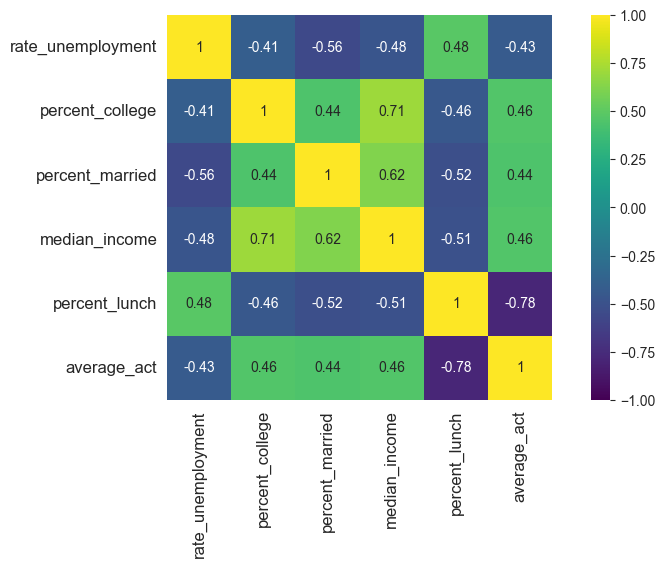

In [85]:
predictor_variables = [
  'rate_unemployment', 
  'percent_college', 
  'percent_married', 
  'median_income', 
  'percent_lunch'
]

numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize=(10, 5))

sns.heatmap(
  corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

We can see that all of the socioeconomic predictor variables have non neligible correlation coefficient with the average ACT. In fact, the correlation between percent lunch and average ACT is -0.78, which is quite large in magnitude. Next, let's make pair plots to explore relationships between the variables

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg

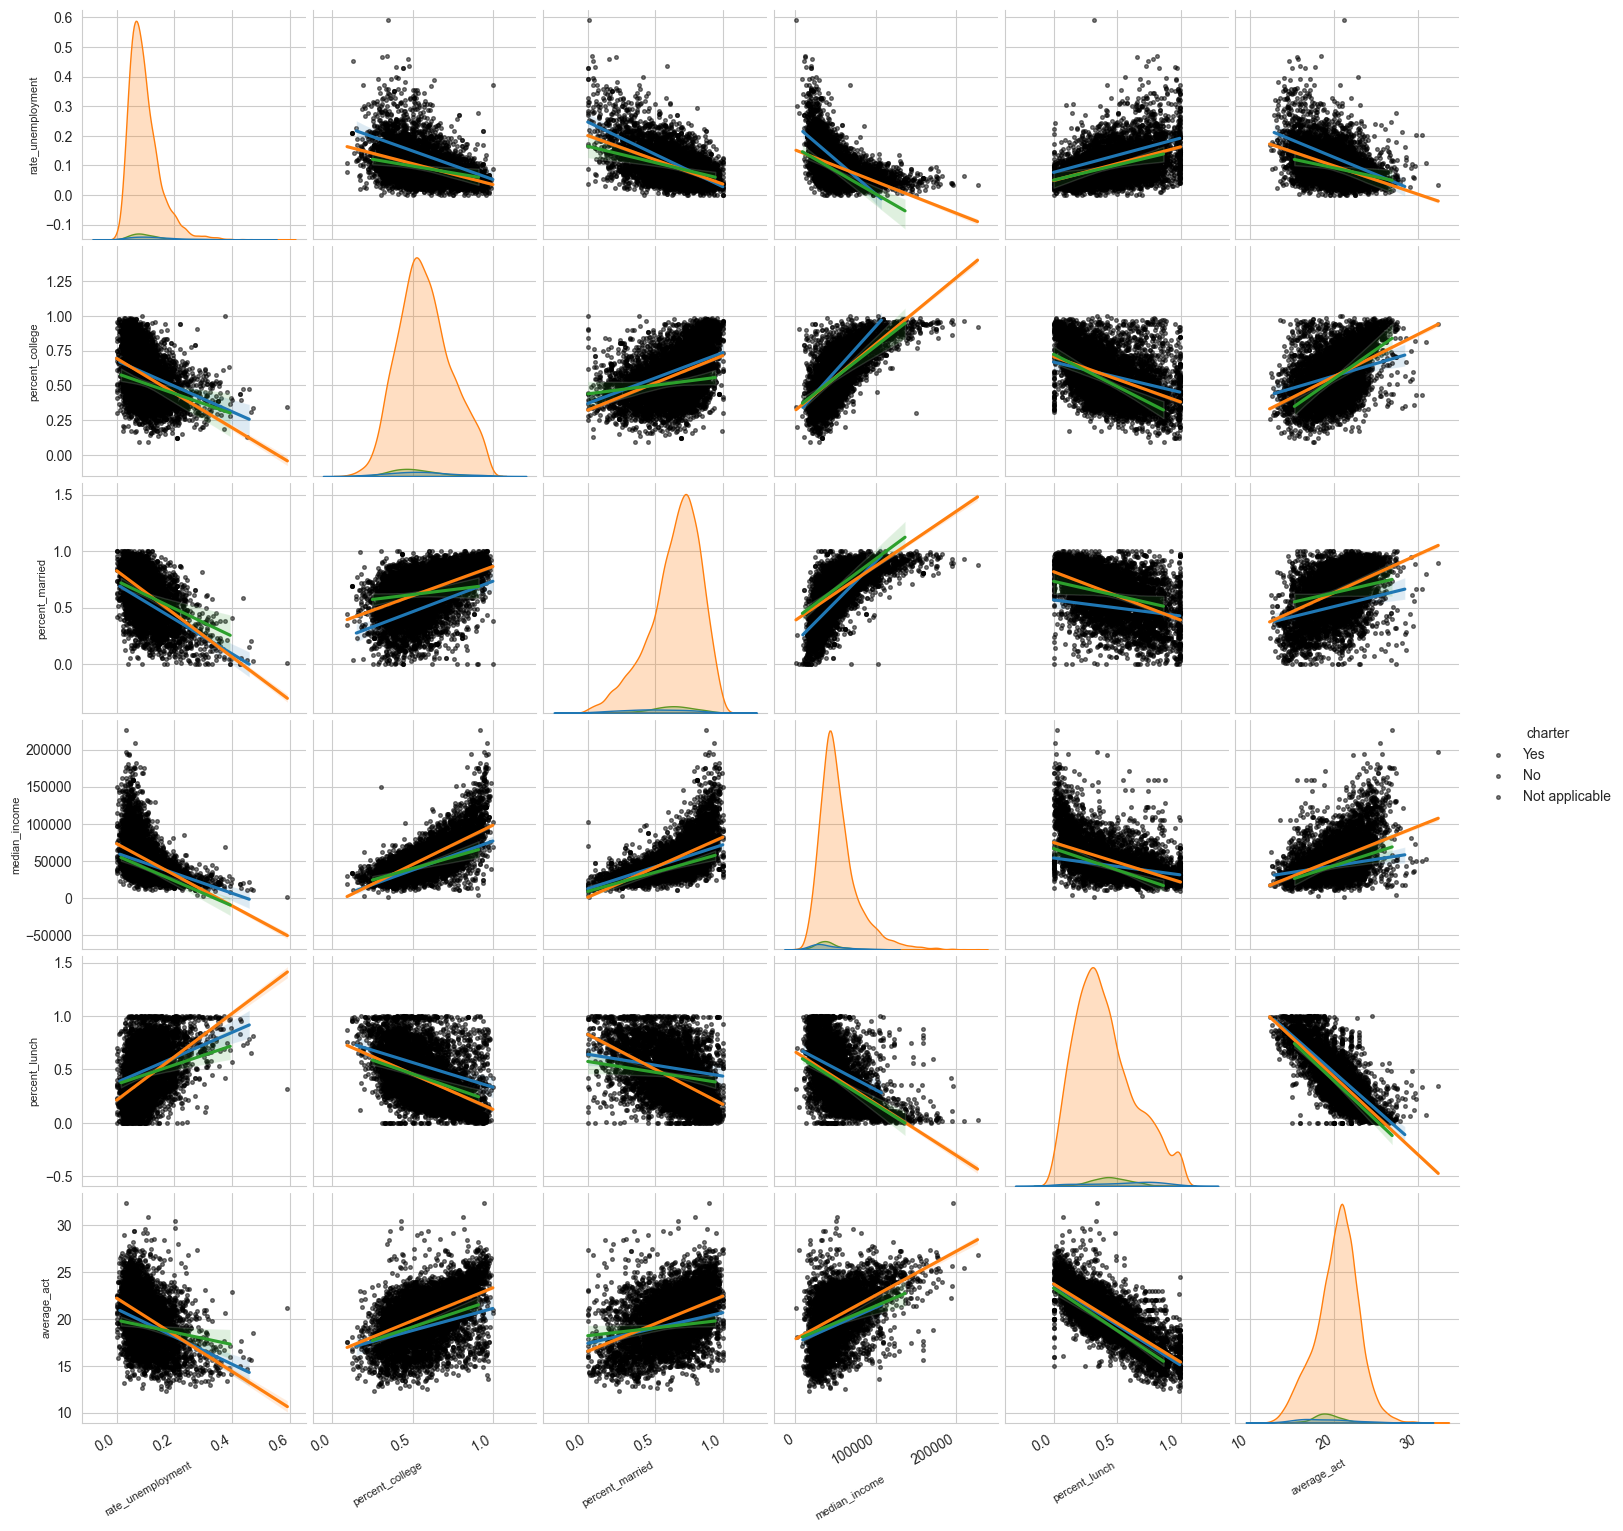

In [86]:
fig = sns.pairplot(
  data=df,
  vars=numerical_predictors + ['average_act'],
  hue='charter',
  kind='reg',
  plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},},
)

for ax in fig.axes.flat:
  if ax.get_xlabel() == 'CT Median Household Income':
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # Apply scientific notation
  ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right') # X-axis label size and rotation
  ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Y-axis label size
  
  # Rotate x-axis tick labels
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  
plt.show()

as we can see in the bottom row of the pair plot, we note that the relationships are quite similar between the different values of whether a school is a charter school or not. Another thing to note is t look at what is the form of the relationship between each of these socioeconomic variables and the average ACT score.

## Identify ourliers

We can use the interquartile range to identify ourliers. This is also evident in boxplots of the data. Median income is on a very different scale than the other predictors, so we will make two plots to explore the data.

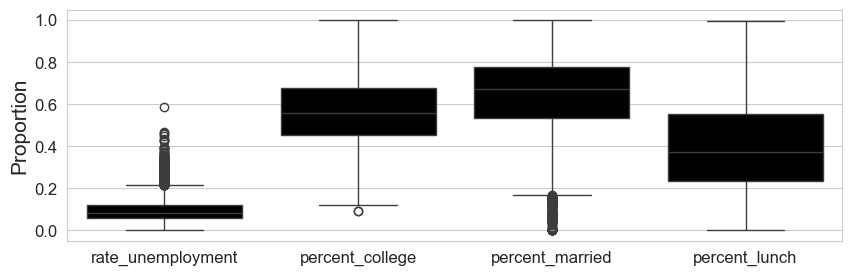

In [87]:
plt.figure(figsize=(10,3))

fractions = list(numerical_predictors)
fractions.remove('median_income')

sns.boxplot(data=df[fractions], color='k')

plt.ylabel('Proportion', fontsize=15)
plt.tick_params(labelsize=12)

plt.show()

This boxplot does show us that the unemployment rate, percent college, and percent married do have outliers. However the values do not seem so far away from the majority of the data, nor do they seem like they are incorrect values so much that we would want to necessarily exclude them from our analysis.

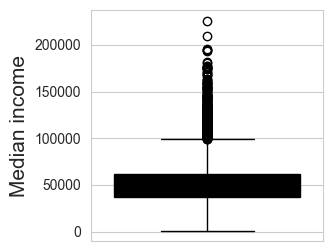

In [88]:
plt.figure(figsize=(3,3))

sns.boxplot(data=df, y='median_income', color='k')

plt.ylabel('Median income', fontsize=15)

plt.show()

This boxplot of median income also has outliers, which typical of income distributions, these values while being technically ourliers, do not look as they are necessarily incorrect. But we should be mindful that these outliers are present in the data.

# Modeling

## Single input models

Fit and assess models predicting the average ACT score from each of the input variables. We might try polynomial linear regression models, as appropriate

### Median imcome

Plot the regression line and the scatter plot

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


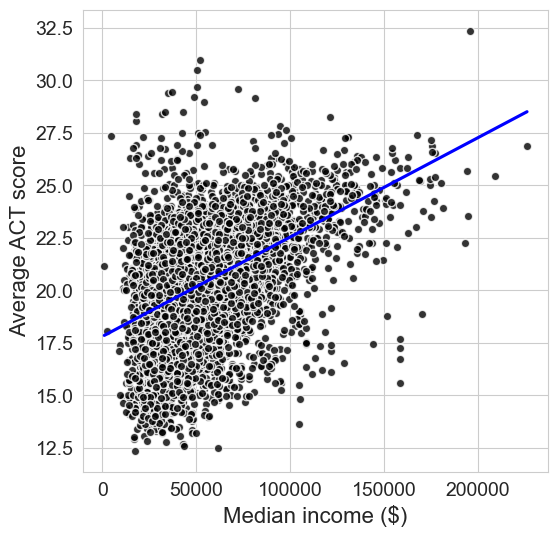

In [89]:
plt.figure(figsize=(6,6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is a relationship between the median income and the average ACT score, and it appears that this simple linear regression is providing only moderate fit of the data. Let's actually fit the model and then we will asses it using graphical and numerical methods

In [90]:
model_median_income = smf.ols(formula='average_act ~ median_income', data=df).fit()
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1934.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:45   Log-Likelihood:                -16043.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.210e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8026      0.063    284.794

This assessment tells us that the intercept in the model is 17.8 and the coefficient on median income is 4.732e-05. It is a very small coefficient because the median income is calculated in dollars and go over a large range, whereas the ACT score is over a much smaller range. We also interested in the statistical significance of the coefficient particularly the one on our predictor, and we can look in the column for the P values to see that they are small and zero up to three decimal places, so we have statistically significant coefficients. Let's compute the R-squared.

In [91]:
model_median_income.rsquared

np.float64(0.21118648979300825)

Compute the RMSE

In [92]:
y_hat = model_median_income.predict()

In [93]:
np.sqrt(mean_squared_error(df['average_act'], y_hat)).round(3)

np.float64(2.228)

Compute the mean absolute error

In [94]:
mean_absolute_error(df['average_act'], y_hat)

1.7129386980688626

From the computation above, the model was not perfect, as we saw, that is a relatively small error in terms of the range of possible values for an ACT score. So it is saying that we are able to in some way predict the ACT score from this particular input variable. We would also like to asses the model using a graphical method and standard approach is to use a residual plot.

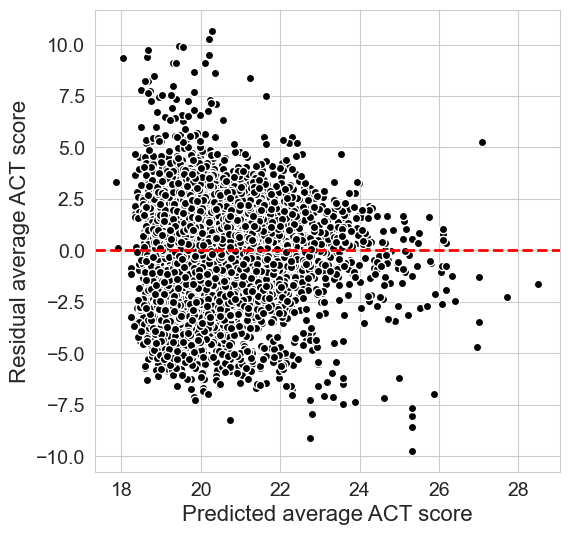

In [95]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

This plot is not purely a cloud of points, the error between what the actual value is and the prediction, that would suggest to use that an alternative model might give us an improvement over the model. So we might try a more complicated model and we could consider a quadratic polynomial regression model. Plot the regression curves and the scatter plot.

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


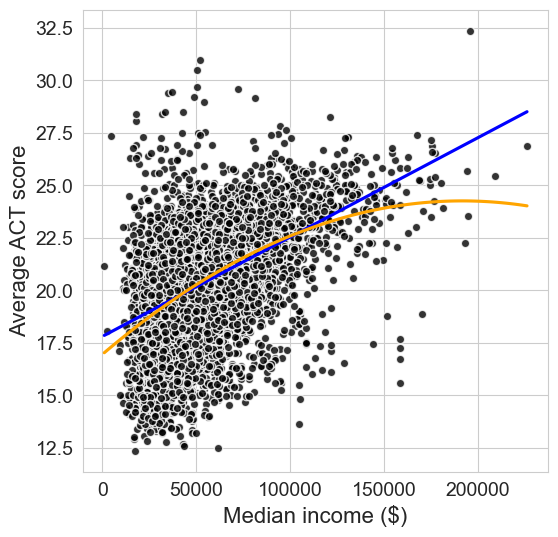

In [96]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            order=2,
            color='orange',
            ci=False,
            scatter=False
            )

plt.xlabel("Median income ($)", fontsize=16)
plt.ylabel("Average ACT score", fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

The qudratic model might provide a slightly better fit, but it is not clear that it is going to be significantly better than the simple linear regression. But we should fit the model and then consider the accuracy and the significance of the quadratic model.

In [97]:
model_median_income2 = smf.ols( # type: ignore
  formula='average_act ~ median_income + I(median_income**2)',
  data=df
).fit()

In [98]:
print(model_median_income2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1013.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:46   Log-Likelihood:                -16007.
No. Observations:                7227   AIC:                         3.202e+04
Df Residuals:                    7224   BIC:                         3.204e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.94

The summary shows that the R-squared is 0.219, and it is very slightly higher than the previous model. The coefficient on the squared term is statistically significant. It is not clear how much that is improving the model. So we have seen from this analysis that we do have a significant quadratic term as well as a significant linear term.

In [99]:
model_median_income2.pvalues

Intercept                0.000000e+00
median_income            2.631899e-99
I(median_income ** 2)    1.395848e-17
dtype: float64

We can use an analysis of variance or ANOVA to compare these two nested plynomial linear regression models where we are comparing the simpler model to the more complicated model and statist significant in terms of its difference from the simpler model.

In [100]:
sms.anova_lm(model_median_income, model_median_income2)

df_resid           ssr  df_diff     ss_diff          F        Pr(>F)
0    7225.0  35865.012794      0.0         NaN        NaN           NaN
1    7224.0  35505.105960      1.0  359.906834  73.227974  1.395848e-17

The P value being quite small and indicating that there is a statistically significant difference. The P value is in fact exactly the same as the P value on the coefficient for the squared term. Let's look at the accuracy of the quadratic model and we will use the mean absolute error.

In [101]:
mean_absolute_error(df['average_act'], model_median_income2.predict())

1.6972389258000675

In [102]:
mean_absolute_error(df['average_act'], model_median_income.predict())

1.7129386980688626

The mean absolute error is 1.69, which if we compare this to the first model is smaller but not practically smaller. So this shows us that we have the ability to look at a relationship between one of our socioeconomic predictor variables and the average ACT score and formulate a model that provides some predictive power of what the ACT score acutally is, but it is a relatively weak prediction. We've also seen that a linear model is probably going to be sufficient to predict the ACT score and that considering something like a quadratic is not necessary going to provide a much better fit.

### Rate Unemployment

Plot the regression line and the scatter plot

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


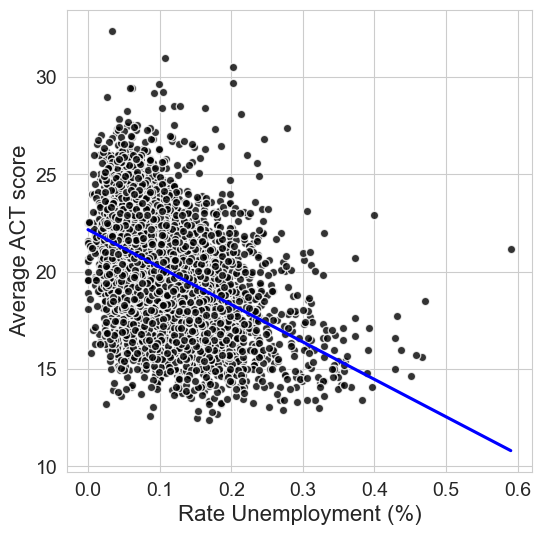

In [103]:
plt.figure(figsize=(6,6))

sns.regplot(data=df,
            x='rate_unemployment',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

plt.xlabel('Rate Unemployment (%)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is a relationship between the rate unemployment and the average ACT score, and it appears that this simple linear regression is providing only moderate fit of the data. Let's actually fit the model and then we will asses it using graphical and numerical methods

In [104]:
model_rate_unemployment = smf.ols(formula='average_act ~ rate_unemployment', data=df).fit()
print(model_rate_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     1669.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:46   Log-Likelihood:                -16149.
No. Observations:                7227   AIC:                         3.230e+04
Df Residuals:                    7225   BIC:                         3.232e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.1512      0.05

This assessment tells us that the intercept in the model is 22.15 and the coefficient on median income is -19.21. We also interested in the statistical significance of the coefficient particularly the one on our predictor, and we can look in the column for the P values to see that they are small and zero up to three decimal places, so we have statistically significant coefficients. Let's compute the R-squared.

Compute the RMSE

In [105]:
y_hat_unemployment = model_rate_unemployment.predict()

In [106]:
np.sqrt(mean_squared_error(df['average_act'], y_hat_unemployment)).round(3)

np.float64(2.261)

From the computation above, the model was not perfect, as we saw, that is a relatively small error in terms of the range of possible values for an ACT score. If we compare this with the median income model, which has RSME is about 1.713, that the median income model is better predictor of ACT score than unemployment rate. We would also like to asses the model using a graphical method and standard approach is to use a residual plot.

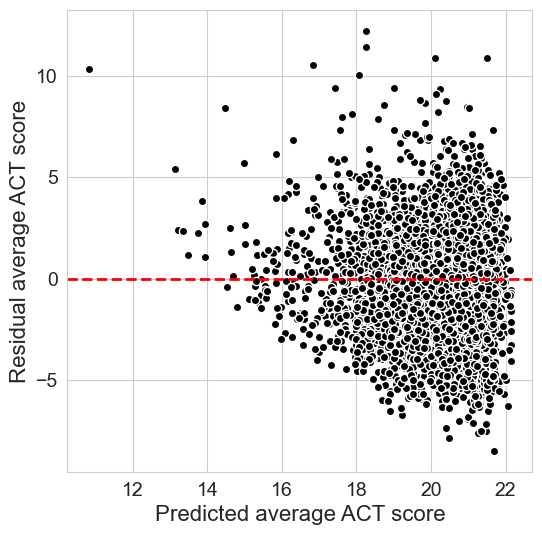

In [107]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat_unemployment, model_rate_unemployment.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


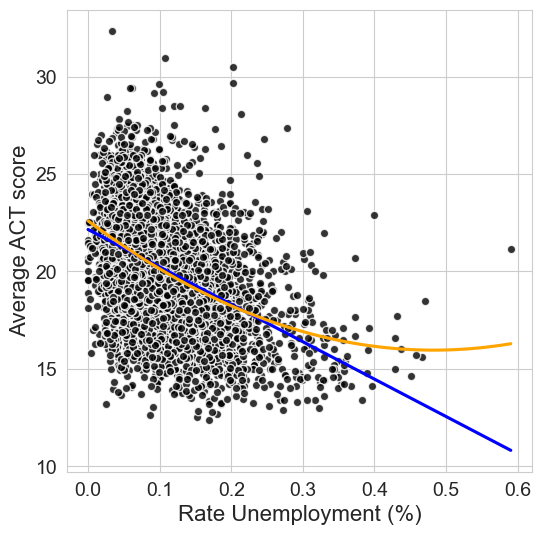

In [108]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='rate_unemployment',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

sns.regplot(data=df,
            x='rate_unemployment',
            y='average_act',
            order=2,
            color='orange',
            ci=False,
            scatter=False
            )

plt.xlabel("Rate Unemployment (%)", fontsize=16)
plt.ylabel("Average ACT score", fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

In [109]:
model_rate_unemployment2 = smf.ols( # type: ignore
  formula='average_act ~ rate_unemployment + I(rate_unemployment**2)',
  data=df
).fit()

In [110]:
print(model_rate_unemployment2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     865.0
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:46   Log-Likelihood:                -16125.
No. Observations:                7227   AIC:                         3.226e+04
Df Residuals:                    7224   BIC:                         3.228e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

The summary shows that the R-squared is 0.193, and it is very slightly higher than the previous model. The coefficient on the squared term is statistically significant. It is not clear how much that is improving the model. So we have seen from this analysis that we do have a significant quadratic term as well as a significant linear term.

In [111]:
model_rate_unemployment2.pvalues

Intercept                     0.000000e+00
rate_unemployment            9.628233e-101
I(rate_unemployment ** 2)     2.360918e-12
dtype: float64

In [112]:
sms.anova_lm(model_rate_unemployment, model_rate_unemployment2)

df_resid           ssr  df_diff     ss_diff          F        Pr(>F)
0    7225.0  36932.894308      0.0         NaN        NaN           NaN
1    7224.0  36682.406013      1.0  250.488295  49.329574  2.360918e-12

In [113]:
mean_absolute_error(df['average_act'], model_rate_unemployment2.predict())

1.7381981457701807

In [114]:
mean_absolute_error(df['average_act'], model_rate_unemployment.predict())

1.7421893796735044

The quadratic model techinically improve the model fit better but the improvement is tiny, from 0.188 to 0.193. The P value being quite small and indicating that there is a statistically significant difference. The P value is in fact exactly the same as the P value on the coefficient for the squared term. The mean absolute error is a little better than first model but not practically bigger. Therefore, the linear model is sufficient to predict ACT score and quadratic is not necessary.

### Percent College

Plot the regression line and the scatter plot

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


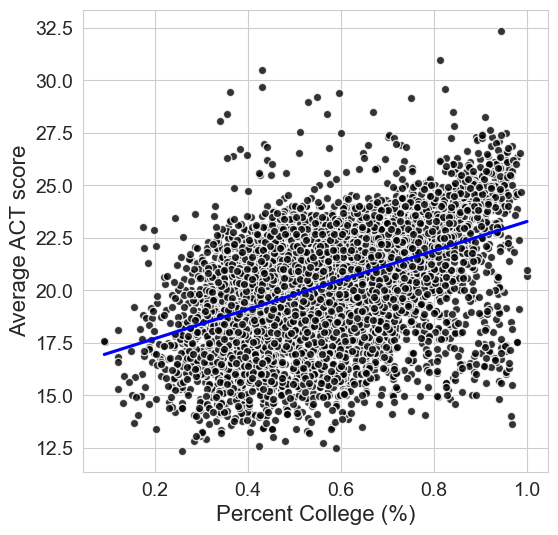

In [115]:
plt.figure(figsize=(6,6))

sns.regplot(data=df,
            x='percent_college',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

plt.xlabel('Percent College (%)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is a relationship between the rate unemployment and the average ACT score, and it appears that this simple linear regression is providing only moderate fit of the data. Let's actually fit the model and then we will asses it using graphical and numerical methods

In [116]:
model_percent_college = smf.ols(formula='average_act ~ percent_college', data=df).fit()
print(model_percent_college.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     1922.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:47   Log-Likelihood:                -16048.
No. Observations:                7227   AIC:                         3.210e+04
Df Residuals:                    7225   BIC:                         3.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.3039      0.095    1

This assessment tells us that the intercept when the percent college at 0 is 16.304, and when the percent of college increase 0.01 then the average ACT score increase by about 0.0697. The R-squared show that about 21% of variation in ACT score can be explain by percent_college. The p-value also show that they are really small and zero up to three decimal places.

Compute the RMSE

In [117]:
y_hat_percent_college = model_percent_college.predict()

In [118]:
np.sqrt(mean_squared_error(df['average_act'], y_hat_percent_college)).round(3)

np.float64(2.229)

Compute the mean absolute error

In [119]:
mean_absolute_error(df['average_act'], y_hat_percent_college)

1.716902423588972

From the computation above, the model was not perfect, as we saw, that is a relatively small error in terms of the range of possible values for an ACT score. So it is saying that we are able to in some way predict the ACT score from this particular input variable. We would also like to asses the model using a graphical method and standard approach is to use a residual plot.

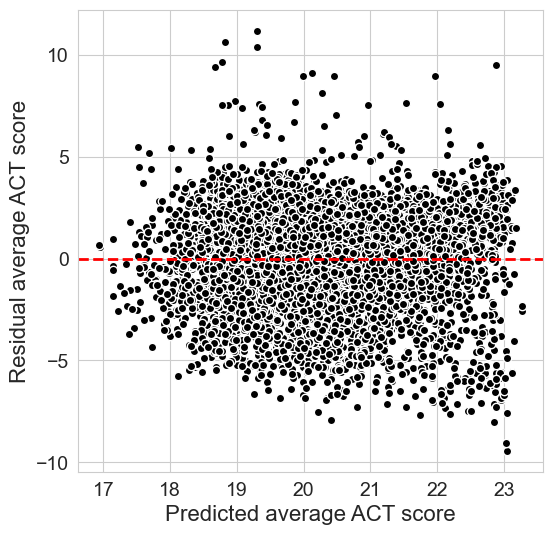

In [120]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat_percent_college, model_percent_college.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

This plot is a cloud of point and look randomly scattered around zero. It looks like the area with more college adults tend to have higher average ACT score, and the linear relationship describe the trend well. Therefore, the linear regression model is sufficient to predict the ACT score.

### Percent Married

Plot the regression line and the scatter plot

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


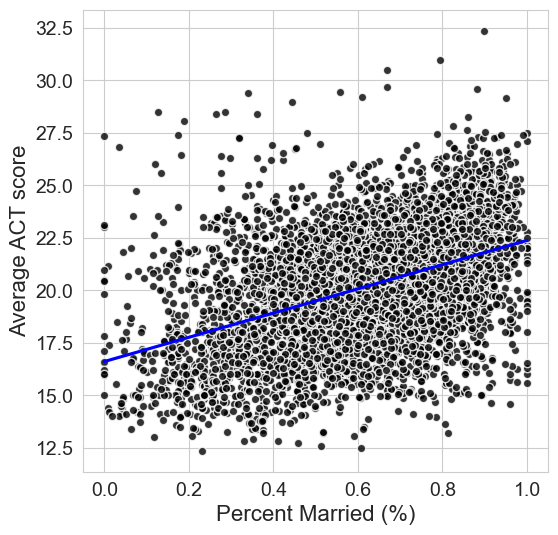

In [121]:
plt.figure(figsize=(6,6))

sns.regplot(data=df,
            x='percent_married',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

plt.xlabel('Percent Married (%)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is a relationship between the adult live in a married family and the average ACT score, and it appears that this simple linear regression is providing only moderate fit of the data. Let's actually fit the model and then we will asses it using graphical and numerical methods

In [122]:
model_percent_married = smf.ols(formula='average_act ~ percent_married', data=df).fit()
print(model_percent_married.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     1733.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:47   Log-Likelihood:                -16124.
No. Observations:                7227   AIC:                         3.225e+04
Df Residuals:                    7225   BIC:                         3.227e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.6046      0.093    1

This assessment tells us that the intercept when the percent college at 0 is 16.604, and when the percent of live in married family increase 0.01 then the average ACT score increase by about 0.058. The R-squared show that about 19% of variation in ACT score can be explain by percent_college. The p-value also show that they are really small and zero up to three decimal places.

Compute the RMSE

In [123]:
y_hat_percent_married = model_percent_married.predict()

In [124]:
np.sqrt(mean_squared_error(df['average_act'], y_hat_percent_married)).round(3)

np.float64(2.253)

Compute the mean absolute error

In [125]:
mean_absolute_error(df['average_act'], y_hat_percent_married)

1.7361820917022133

From the computation above, the model was not perfect, as we saw, that is a relatively small error in terms of the range of possible values for an ACT score. So it is saying that we are able to in some way predict the ACT score from this particular input variable. We would also like to asses the model using a graphical method and standard approach is to use a residual plot.

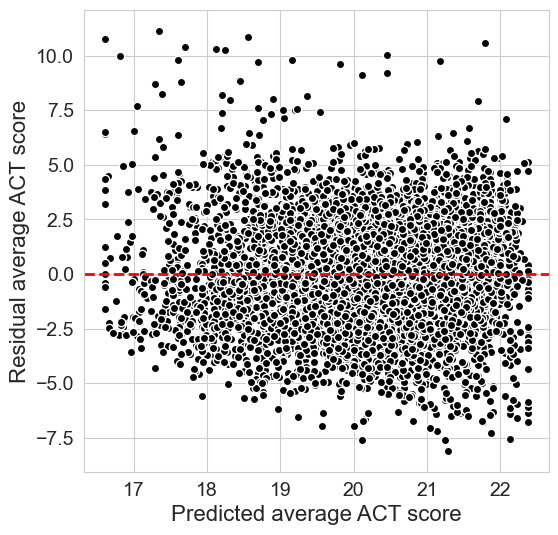

In [126]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat_percent_married, model_percent_married.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

This plot is a cloud of point and look randomly scattered around zero. It looks like the area with more adult live in a married family tend to have higher average ACT score, and the linear relationship describe the trend well. Therefore, the linear regression model is sufficient to predict the ACT score.

### Percent Lunch

Plot the regression line and the scatter plot

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


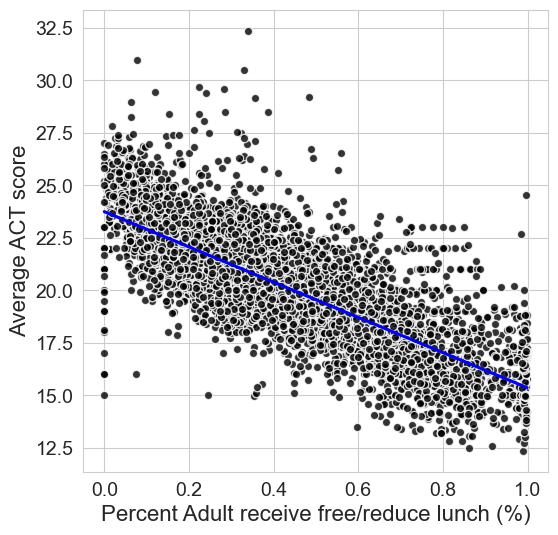

In [127]:
plt.figure(figsize=(6,6))

sns.regplot(data=df,
            x='percent_lunch',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

plt.xlabel('Percent Adult receive free/reduce lunch (%)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is a relationship between the percent adult receive free/reduce price for lunch and the average ACT score, and it appears that this simple linear regression is providing only moderate fit of the data. Let's actually fit the model and then we will asses it using graphical and numerical methods

In [128]:
model_percent_lunch = smf.ols(formula='average_act ~ percent_lunch', data=df).fit()
print(model_percent_lunch.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.149e+04
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:47   Log-Likelihood:                -13461.
No. Observations:                7227   AIC:                         2.693e+04
Df Residuals:                    7225   BIC:                         2.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7429      0.037    641.745

This assessment tells us that the intercept when the percent college at 0 is 23.74, and when the percent of adult receive free or reduce price for lunch increase 0.01 then the average ACT score decrease by about 0.084. The R-squared show that about 61% of variation in ACT score can be explain by percent_lunch. The p-value also show that they are really small and zero up to three decimal places.

Compute the RMSE

In [129]:
y_hat_percent_lunch = model_percent_lunch.predict()

In [130]:
np.sqrt(mean_squared_error(df['average_act'], y_hat_percent_lunch)).round(3)

np.float64(1.559)

Compute the mean absolute error

In [131]:
mean_absolute_error(df['average_act'], y_hat_percent_lunch)

1.1689939374388378

From the computation above, the model was not perfect, as we saw, that is a relatively small error in terms of the range of possible values for an ACT score. So it is saying that we are able to in some way predict the ACT score from this particular input variable. We would also like to asses the model using a graphical method and standard approach is to use a residual plot.

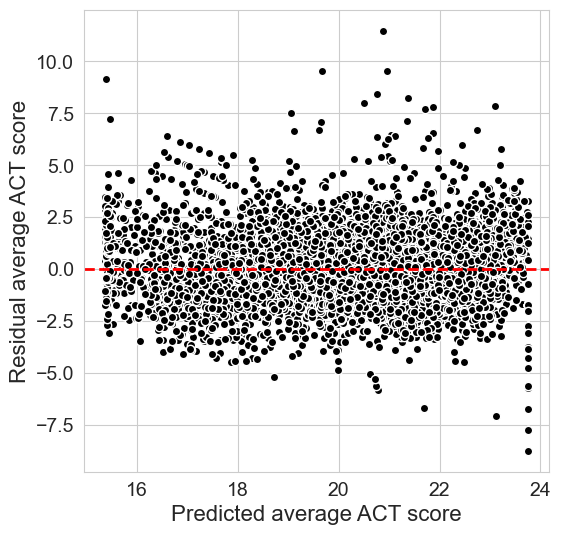

In [132]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat_percent_lunch, model_percent_lunch.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

The model using percent_lunch as a predictor is both statistically strong and practically meaningful. The linear regression captures a clear, negative relationship between socioeconomic disadvantage and ACT performance, explains most of the score variation, and produces unbiased residuals.

## Multiple linear regression

We are now going to fit a multiple linear regression model including all of the predictors that we would like to use in the model using all socioeconomic variables

In [133]:
model = smf.ols(
  formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch',
  data=df).fit()

In [134]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2438.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:48   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.667e+04
Df Residuals:                    7221   BIC:                         2.671e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6972      0.13

We see that we have two of our model coefficients that are not statistically significant. The coefficient on percent_married and median_income have relatively large P values, indicating that they are not statistically significant. We noticed in our exploratory data analysis that there were correlations among these predictor variables, so it make sense that we do not need all of these predictors in a single model. We also note that the R-squared is roughly 0.63, which much higher than what we had seen with any of our individual predict models. We can use a residual plot for a graphical assessment of the model fit to see if we have used these predictor variables in the best way possible or if there's some transformation that we might apply to improve the fit.

In [135]:
y_hat = model.predict()

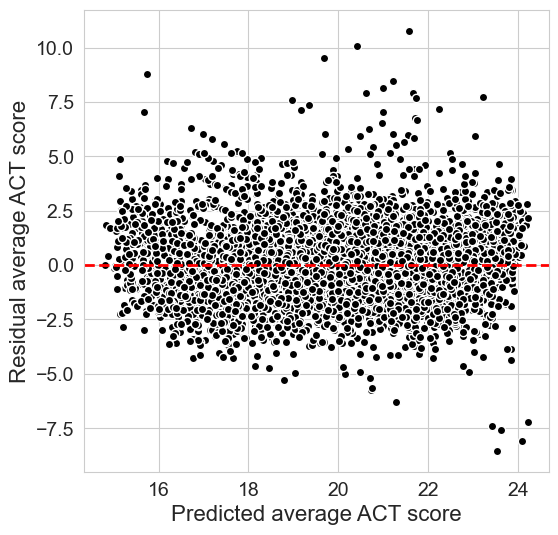

In [136]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

This plot shows that there is relatively no structure to the residual plot, indicating that we are unlikely to improve the model by making transformations of the input variables that we have used in the model. We can also do a numerical assessment of the accuracy of the model and looking at the mean absolute error.

In [137]:
mean_absolute_error(df['average_act'], model.predict())

1.1453304788871166

This is less than what we were seeing in the individual predictor models. After fitting the full multiple linear regression model including all of the socioeconomic predictor varables that we wanted to include, and finding that some of the coefficient were not statistically significant. We will fit a reduced model that only includes those predictor variables that has statistically significant coefficients and see if that reduced model is sufficient to predict the average ACT score. In this case, we only include unemployment rate, percent college, and the percent of students eligible for free or reduced price lunch in the model

In [138]:
model_reduced = smf.ols(
  formula='average_act ~ rate_unemployment + percent_college + percent_lunch',
  data=df).fit()

In [139]:
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4063.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:48   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6400      0.10

We do have all three of these variable having statistically significant coefficients. We can use a residual plot for a graphical assessment of this model fit and see that we have a very similar residual plot to what we had with the full model.

In [140]:
y_hat_reduced = model_reduced.predict()

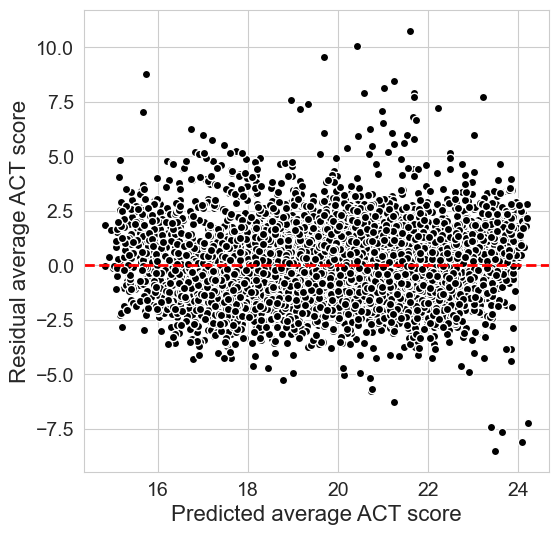

In [141]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat_reduced, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

This is again essentially no structure to the model, indicating that we do not need to include transformations of these particular predicotrs in order to improve the model. We can do a numerical assessment of the accuracy again using the mean absolute error.

In [142]:
mean_absolute_error(df['average_act'], model_reduced.predict())

1.1454832950346372

This looks very similar to what we had with the full model. In fact, when we compare the accuracy of the model in terms of the mean absolute error or R-squared between the reduced model and the full model that included all five predictor variables, they are essentially equivalent.

In [143]:
mae_full = mean_absolute_error(df['average_act'], model.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r2_full = model.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced],
              'R-squared': [r2_full, r2_reduced]},
              index=['full model', 'reduced model']).round(4)

Mean Absolute Error  R-squared
full model                  1.1453     0.6280
reduced model               1.1455     0.6279

We can also consider the significance of the difference between the model using an ANOVA.

In [144]:
sms.anova_lm(model_reduced, model)

df_resid           ssr  df_diff   ss_diff         F    Pr(>F)
0    7223.0  16916.619167      0.0       NaN       NaN       NaN
1    7221.0  16915.612457      2.0  1.006711  0.214874  0.806648

We can see that there is no statistically significant difference between the reduced model that just included those three predictor variables and the larger model that had five of socioeconomic predictor variables. Now, we are going to scale the predictors in the reduced model so that they have a mean of 0 and a standard deviation of 1. So that we can use the magnitude of the coefficients in this model to compare the relative importance of each of those predictor variables at contributing to our estimate of the average ACT score.

In [145]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_lunch']

In [146]:
scaled_columns = [var + '_normalized' for var in predictor_variables]

print(scaled_columns)

['rate_unemployment_normalized', 'percent_college_normalized', 'percent_lunch_normalized']


In [147]:
scaler = StandardScaler().fit(df[predictor_variables])

In [148]:
df[scaled_columns] = scaler.transform(df[predictor_variables])

Now let's check and see that these new variables do in fact have a mean of 0 and a standard deviation of 1. We might expect there to be some small differences just due to calculation error, and they do have means of essentially zero and standard deviations of one.

In [149]:
df[scaled_columns].agg(['mean', 'std']).round(3)

rate_unemployment_normalized  percent_college_normalized  \
mean                           0.0                        -0.0   
std                            1.0                         1.0   

      percent_lunch_normalized  
mean                       0.0  
std                        1.0

So now we can fit the multiple linear regression model with those normalized predictors. So we will use again three values in the reduced model for them to have statistically significant coefficents. 

In [150]:
model_normalize = smf.ols(
  formula='average_act ~ rate_unemployment_normalized + percent_college_normalized + percent_lunch_normalized',
  data=df).fit()

In [151]:
print(model_normalize.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4063.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:49:48   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

We see that we have a much larger magnitude of a coefficient for the percent lunch variable than for either of the other two variables. So this says that the estimated change in the average ACT score is much larger magnitude when we would have a one standard deviation change in the percent lunch variable as comapred to the percent college or the unemployment rate variable. We may be noting that R squared value looks like it is the same as what we had with our reduced model. Let's compare the accuracy between the original and normalized models.

In [152]:
mae_normalized = mean_absolute_error(df['average_act'], model_normalize.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r2_normalized = model_normalize.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_normalized, mae_reduced],
              'R-squared': [r2_normalized, r2_reduced]},
              index=['normalized model', 'reduced model']).round(4)

Mean Absolute Error  R-squared
normalized model               1.1455     0.6279
reduced model                  1.1455     0.6279

In fact, when we compare all of these numerical measures, the mean absolute error or the R-squared, they are exactly the same between the model with the unscaled predictors and with these scaled predictors. This is because the transformation from the original predictors to the standardized versions does not lead to an overall change in the linear regression model, it is just changing what the coefficients in that model are .

## Additional Predictor: Neighborhood Poverty Rate

To extend the baseline socioeconomic model, I include the **neighborhood poverty rate** from the NCES School Neighborhood Poverty Estimates dataset as an additional predictor.  
While EdGap already provides school-level socioeconomic indicators such as median family income and percentage of students receiving free or reduced-price lunch, these metrics reflect conditions within schools. The neighborhood poverty rate, on the other hand, captures the broader **economic environment around the school**, which may influence access to resources, peer effects, and community support.  

This variable helps test whether the **local economic context** adds explanatory power beyond what school-level socioeconomic factors already capture.  
However, because poverty rate and median income are conceptually related, I will later check for multicollinearity and interpret results carefully when both are included in the same model.

Now we are going to load new dataset to get more variables

In [153]:
new_df = pd.read_csv('../data/education_clean_v2.csv')

Plot the correlation matrix of the numerical variables in the training data to explore relationships between the variables.

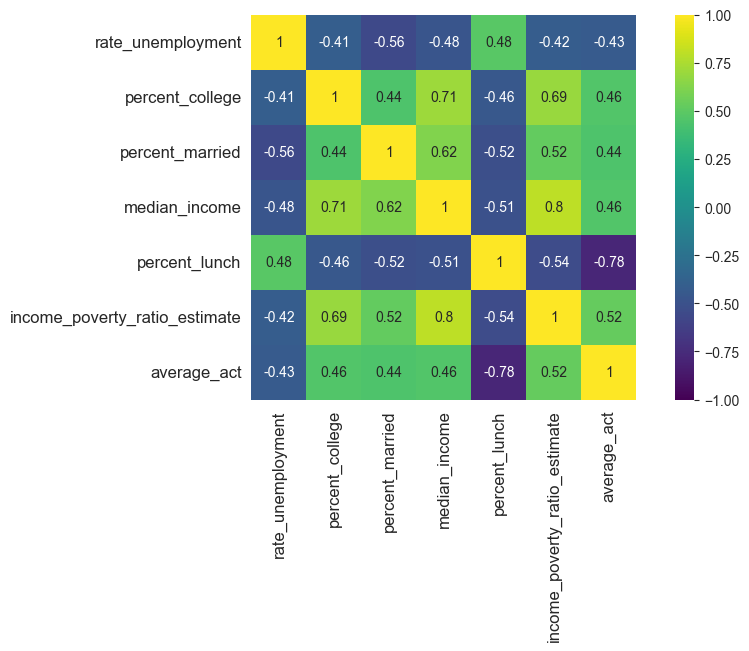

In [154]:
predictor_variables = [
  'rate_unemployment', 
  'percent_college', 
  'percent_married', 
  'median_income', 
  'percent_lunch',
  'income_poverty_ratio_estimate'
]

numerical_predictors = new_df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = new_df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize=(10, 5))

sns.heatmap(
  corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

We can see that the correlation between income_poverty_ratio_estimate and average_act is 0.52, which is lager than other variables that have possitive correlation and it is the biggest in magnitude. Next, let's make pair plots to explore relationships between the variables

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg

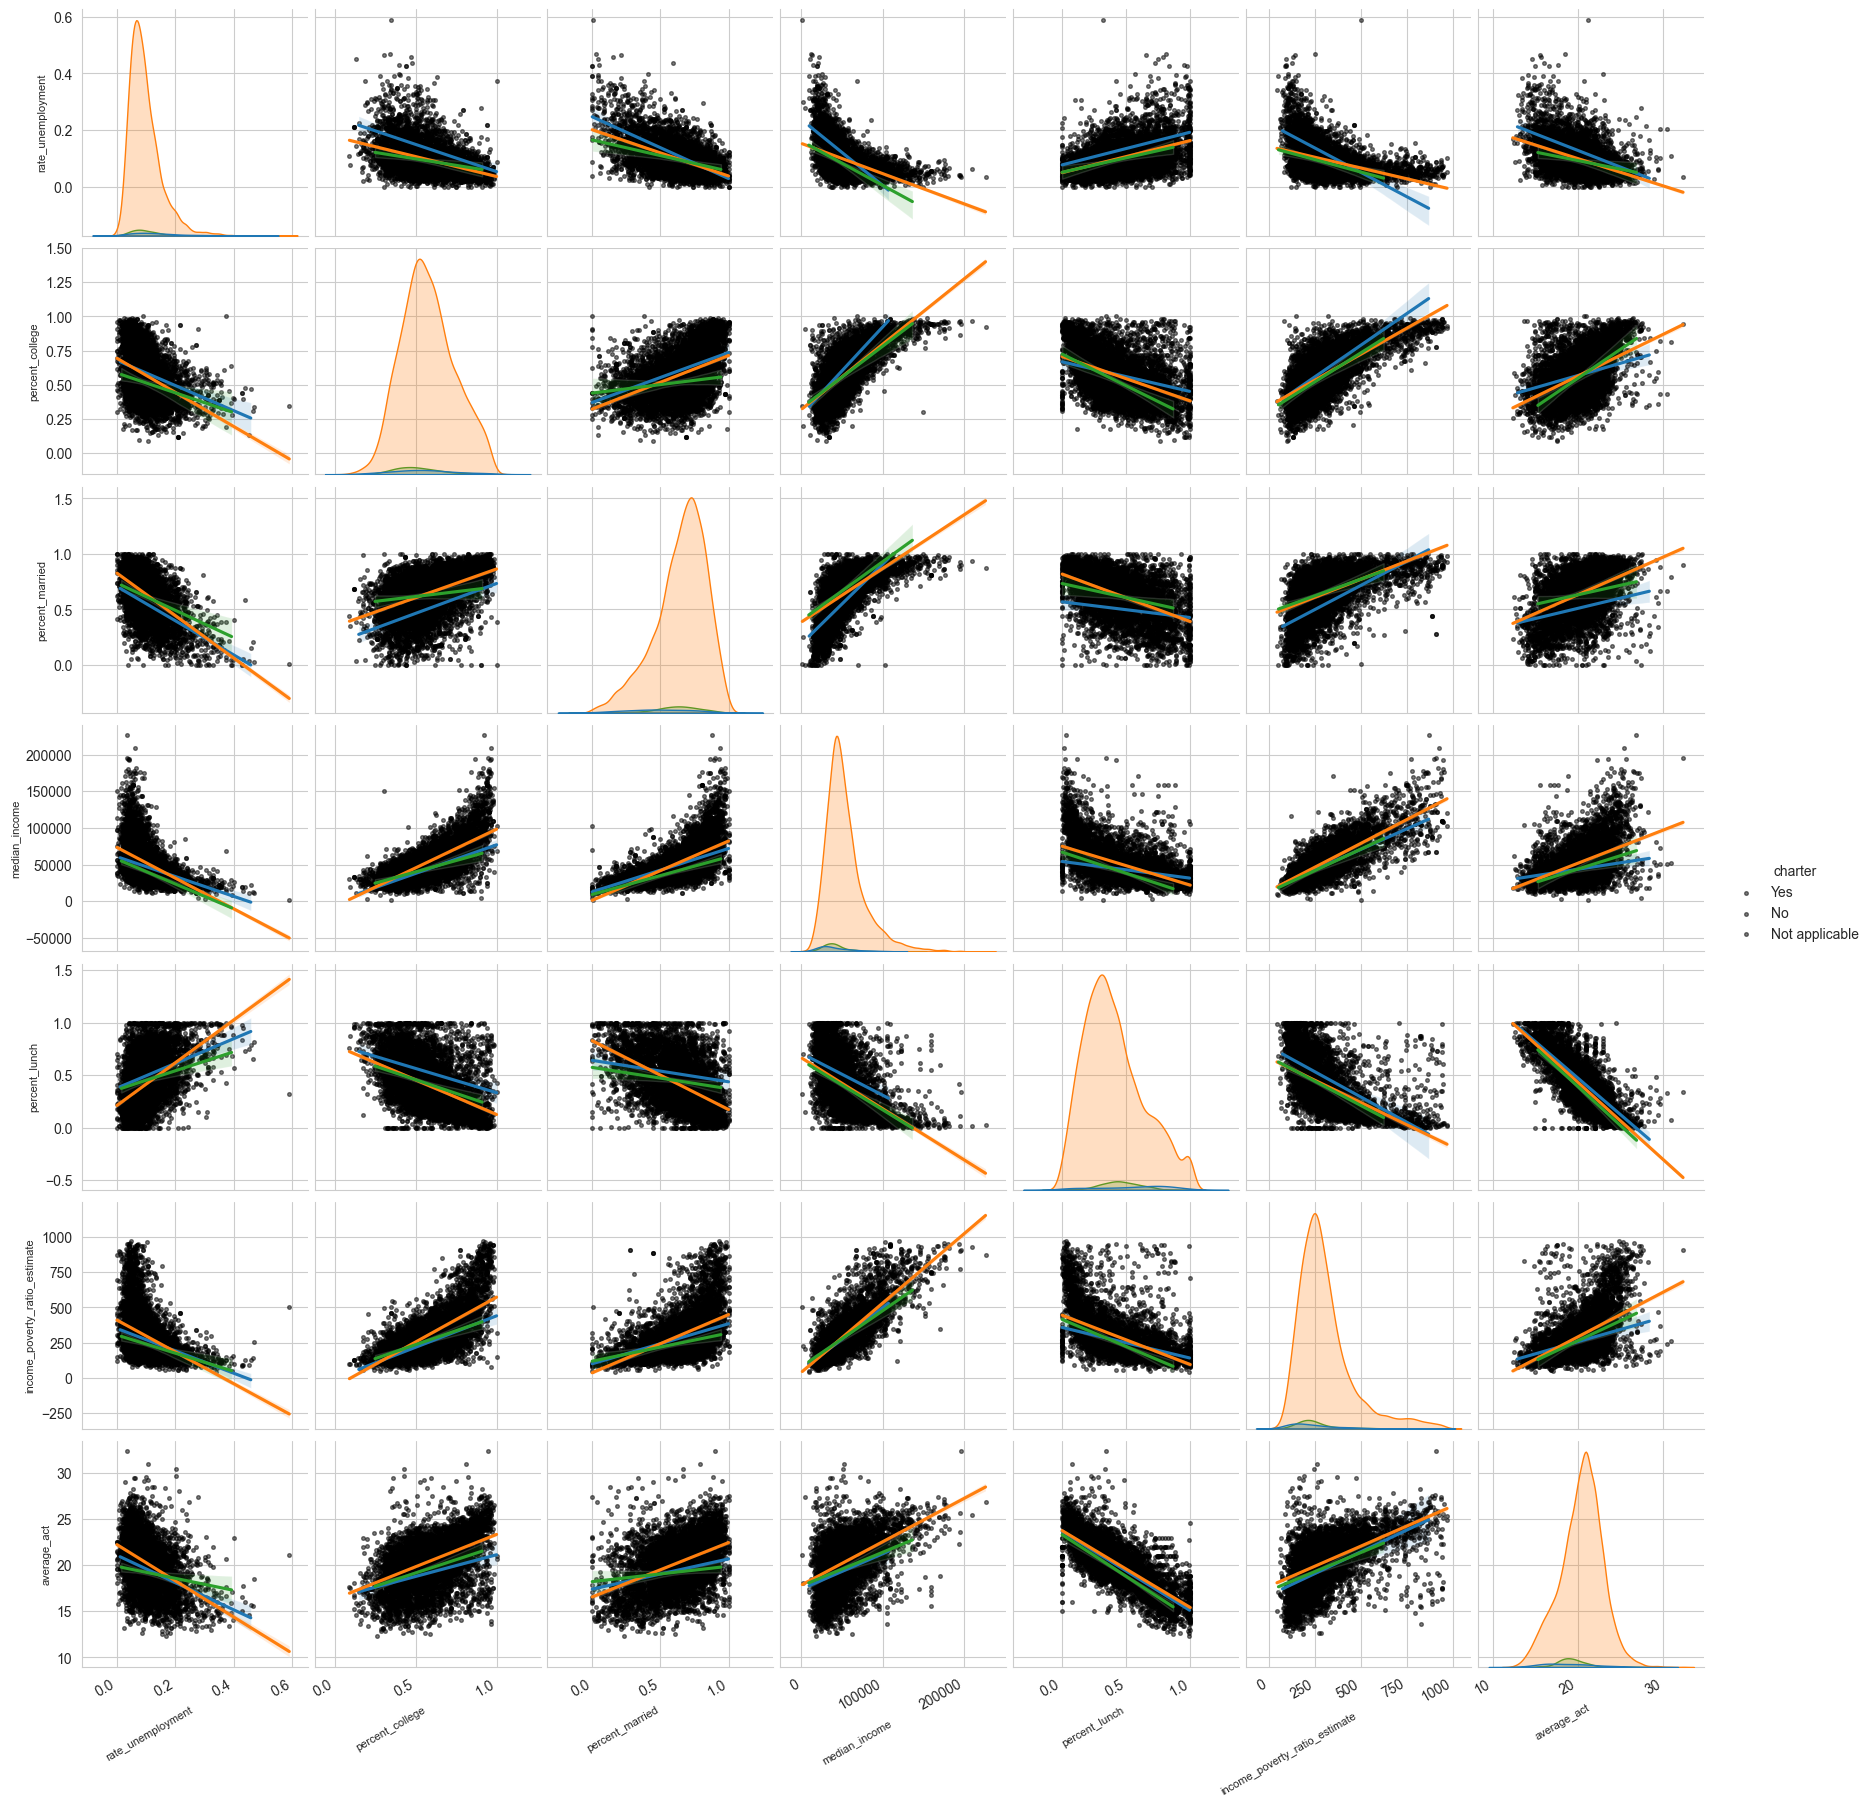

In [155]:
fig = sns.pairplot(
  data=new_df,
  vars=numerical_predictors + ['average_act'],
  hue='charter',
  kind='reg',
  plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},},
)

for ax in fig.axes.flat:
  if ax.get_xlabel() == 'CT Median Household Income':
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # Apply scientific notation
  ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right') # X-axis label size and rotation
  ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Y-axis label size
  
  # Rotate x-axis tick labels
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  
plt.show()

We can use the interquartile range to identify ourliers. This is also evident in boxplots of the data for income_poverty_ratio_estimate

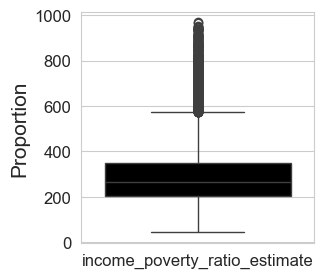

In [156]:
plt.figure(figsize=(3,3))

sns.boxplot(data=new_df[['income_poverty_ratio_estimate']], color='k')

plt.ylabel('Proportion', fontsize=15)
plt.tick_params(labelsize=12)

plt.show()

The boxplot shows that the income_poverty_ratio_estimate variable contains several outliers. These represent schools located in neighborhoods with income-to-poverty ratios significantly higher than most others, suggesting a skewed distribution toward higher-income areas. Let fit and assess the model predicting the average ACT score from income poverty ratio estimate.

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


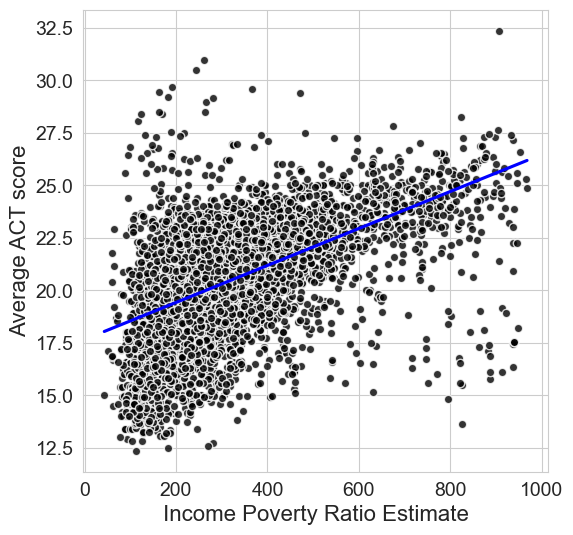

In [157]:
plt.figure(figsize=(6,6))

sns.regplot(data=new_df,
            x='income_poverty_ratio_estimate',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

plt.xlabel('Income Poverty Ratio Estimate', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

There is a relationship between the income poverty ratio estimate and the average ACT score, and it appears that this simple linear regression is providing only moderate fit of the data. Let's actually fit the model and then we will asses it using graphical and numerical methods

In [158]:
model_income_poverty_estimate = smf.ols(formula='average_act ~ income_poverty_ratio_estimate', data=new_df).fit()
print(model_income_poverty_estimate.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     2740.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:50:01   Log-Likelihood:                -15739.
No. Observations:                7227   AIC:                         3.148e+04
Df Residuals:                    7225   BIC:                         3.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

This assessment tells us that the intercept in the model is 17.65 and the coefficient on income_poverty_ratio_estimate is 0.0088. It is a small coefficient. We also interested in the statistical significance of the coefficient particularly the one on our predictor, and we can look in the column for the P values to see that they are small and zero up to three decimal places, so we have statistically significant coefficients. Let's compute the R-squared.

In [159]:
model_income_poverty_estimate.rsquared

np.float64(0.2749858672251154)

The R-squared show that about 27.5 variants in the average ACT score can be explained by the income_poverty_ratio_estimate. Let's compute the RMSE and the mean absolute error.

In [160]:
y_hat_income_poverty = model_income_poverty_estimate.predict()

In [161]:
np.sqrt(mean_squared_error(new_df['average_act'], y_hat_income_poverty)).round(3)

np.float64(2.136)

In [162]:
mean_absolute_error(df['average_act'], y_hat_income_poverty)

1.619754091555486

From the computation above, the model was not perfect, as we saw, that is a relatively small error in terms of the range of possible values for an ACT score. So it is saying that we are able to in some way predict the ACT score from this particular input variable. We would also like to asses the model using a graphical method and standard approach is to use a residual plot.

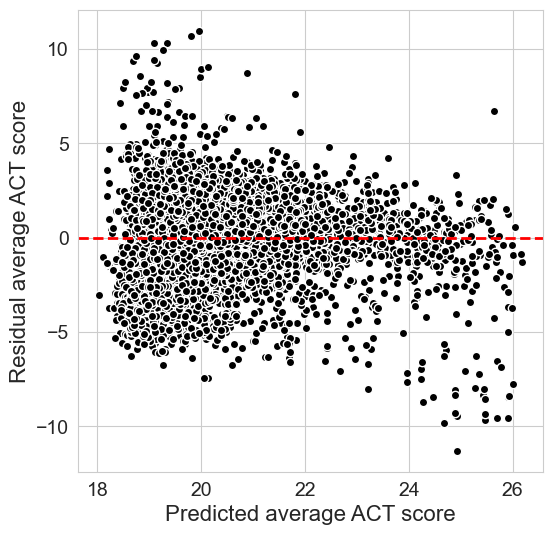

In [163]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat_income_poverty, model_income_poverty_estimate.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

From the plot we can see there is maybe a downward trend as predicted ACT score increase which might be overpredict for high ACT score. Since the plot is not purely a cloud of points, we might try a more complicated model and we could consider a quadratic polynomial regression model.

/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/congho/su-homework/data-5100-foundations-of-data-science/education/venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


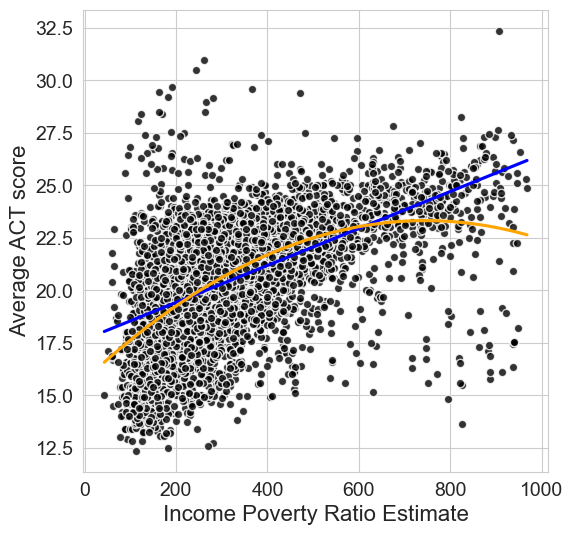

In [164]:
plt.figure(figsize=(6, 6))

sns.regplot(data=new_df,
            x='income_poverty_ratio_estimate',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
            )

sns.regplot(data=new_df,
            x='income_poverty_ratio_estimate',
            y='average_act',
            order=2,
            color='orange',
            ci=False,
            scatter=False
            )

plt.xlabel("Income Poverty Ratio Estimate", fontsize=16)
plt.ylabel("Average ACT score", fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

The qudratic model might provide a slightly better fit, but it is not clear that it is going to be significantly better than the simple linear regression. But we should fit the model and then consider the accuracy and the significance of the quadratic model.

In [165]:
model_income_poverty_estimate2 = smf.ols( # type: ignore
  formula='average_act ~ income_poverty_ratio_estimate + I(income_poverty_ratio_estimate**2)',
  data=new_df
).fit()

In [166]:
print(model_income_poverty_estimate2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     1649.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:50:02   Log-Likelihood:                -15542.
No. Observations:                7227   AIC:                         3.109e+04
Df Residuals:                    7224   BIC:                         3.111e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

The summary shows that the R-squared is 0.313, and it is very slightly higher than the previous model. The coefficient on the squared term is statistically significant. It is not clear how much that is improving the model. So we have seen from this analysis that we do have a significant quadratic term as well as a significant linear term.

In [167]:
model_income_poverty_estimate2.pvalues

Intercept                                 0.000000e+00
income_poverty_ratio_estimate            8.124518e-236
I(income_poverty_ratio_estimate ** 2)     1.553277e-87
dtype: float64

We can use an analysis of variance or ANOVA to compare these two nested polynomial linear regression models where we are comparing the simpler model to the more complicated model and statist significant in terms of its difference from the simpler model.

In [168]:
sms.anova_lm(model_income_poverty_estimate, model_income_poverty_estimate2)

df_resid           ssr  df_diff      ss_diff           F        Pr(>F)
0    7225.0  32964.244161      0.0          NaN         NaN           NaN
1    7224.0  31217.254238      1.0  1746.989923  404.271788  1.553277e-87

The P value being quite small and indicating that there is a statistically significant difference. The P value is in fact exactly the same as the P value on the coefficient for the squared term. Let's look at the accuracy of the quadratic model and we will use the mean absolute error.

In [169]:
mean_absolute_error(new_df['average_act'], model_income_poverty_estimate2.predict())

1.5685820578069967

In [170]:
mean_absolute_error(new_df['average_act'], model_income_poverty_estimate.predict())

1.619754091555486

The mean absolute error is 1.57, which if we compare this to the first model is smaller but not practically smaller. So this shows us that we have the ability to look at a relationship between one of our socioeconomic predictor variables and the average ACT score and formulate a model that provides some predictive power of what the ACT score acutally is, but it is a relatively weak prediction. We've also seen that a linear model is probably going to be sufficient to predict the ACT score and that considering something like a quadratic is not necessary going to provide a much better fit.

We are now going to fit a multiple linear regression model including all of the predictors that we would like to use in the model using all socioeconomic variables and a new variable to support more accuracy of predicting ACT score.

In [171]:
new_model = smf.ols(
  formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch + income_poverty_ratio_estimate',
  data=new_df).fit()

In [172]:
print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     2079.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:50:02   Log-Likelihood:                -13275.
No. Observations:                7227   AIC:                         2.656e+04
Df Residuals:                    7220   BIC:                         2.661e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

When income_poverty_ratio_estimate was added to the model, the coefficient for median_income became statistically significant. However, the change is likely due to multicollinearity among income-related variables rather than a new substantive effect. Both variables measure similar aspects of socioeconomic status, and the inflated condition number indicates instability in the estimates. To improve interpretability, one of these correlated predictors should be removed before drawing conclusions about income effects on ACT performance. We can use a residual plot for a graphical assessment of the model fit to see if we have used these predictor variables in the best way possible or if there's some transformation that we might apply to improve the fit.

In [173]:
new_y_hat = model.predict()

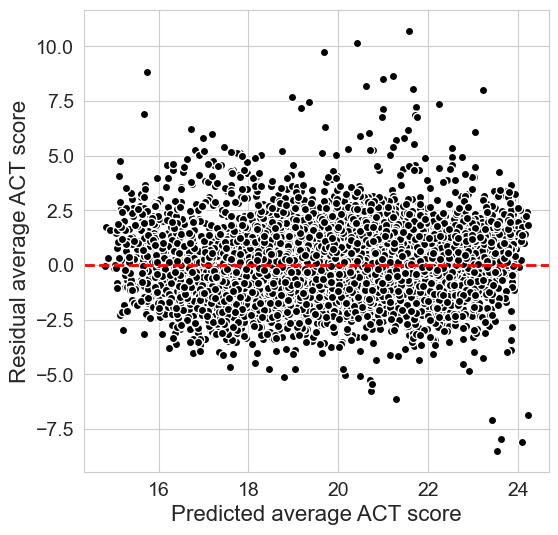

In [174]:
plt.figure(figsize=(6, 6))

plt.plot(new_y_hat, new_model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

This plot shows that there is relatively no structure to the residual plot, indicating that we are unlikely to improve the model by making transformations of the input variables that we have used in the model. We can also do a numerical assessment of the accuracy of the model and looking at the mean absolute error.

In [175]:
mean_absolute_error(new_df['average_act'], new_model.predict())

1.1337795633858112

This is lees then the old model. Next we will fit a reduced model that only includes those predictor variables that has statistically significant coefficients and see if that reduced model is sufficient to predict the average ACT score. In this case, we only include unemployment rate, percent college, and the percent of students eligible for free or reduced price lunch, and income poverty ratio estimae in the model. Since the income_poverty_ratio_estimate is describe the context similar to the median income but it show the ratio income for the neighborhood around the school, not necessarily the actual income backgrounds of the enrolled students.

In [176]:
new_model_reduced = smf.ols(
  formula='average_act ~ rate_unemployment + percent_college + percent_lunch + income_poverty_ratio_estimate',
  data=new_df).fit()

In [177]:
print(new_model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     3094.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:50:02   Log-Likelihood:                -13293.
No. Observations:                7227   AIC:                         2.660e+04
Df Residuals:                    7222   BIC:                         2.663e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

We do have all four of these variables having statistically significant coefficients. We can use a residual plot for a graphical assessment of this model fit and see that we have a very similar residual plot to what we had with the full model.

In [178]:
new_y_hat_reduced = new_model_reduced.predict()

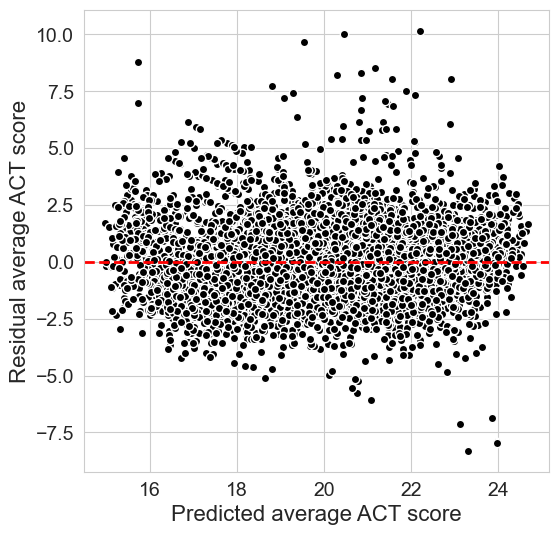

In [179]:
plt.figure(figsize=(6, 6))

plt.plot(new_y_hat_reduced, new_model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

This is again essentially no structure to the model, indicating that we do not need to include transformations of these particular predictors in order to improve the model. We can do a numerical assessment of the accuracy again using the mean absolute error.

In [180]:
mean_absolute_error(new_df['average_act'], new_model_reduced.predict())

1.1383027484766703

This look slightly larger than the full model. In fact, when we compare the accuracy of the model in terms of the mean absolute error or R-squared between the reduced model and the full model that included all six predictor variables, the reduced model has slightly smaller value.

In [181]:
new_mae_full = mean_absolute_error(new_df['average_act'], new_model.predict())
new_mae_reduced = mean_absolute_error(new_df['average_act'], new_model_reduced.predict())

new_r2_full = new_model.rsquared
new_r2_reduced = new_model_reduced.rsquared

pd.DataFrame({'New Mean Absolute Error': [new_mae_full, new_mae_reduced],
              'New R-squared': [new_r2_full, new_r2_reduced]},
              index=['new full model', 'new reduced model']).round(4)

New Mean Absolute Error  New R-squared
new full model                      1.1338         0.6333
new reduced model                   1.1383         0.6315

We can also consider the significance of the difference between the model using an ANOVA.

In [182]:
sms.anova_lm(new_model_reduced, new_model)

df_resid           ssr  df_diff    ss_diff          F        Pr(>F)
0    7222.0  16754.972033      0.0        NaN        NaN           NaN
1    7220.0  16670.754967      2.0  84.217066  18.236943  1.258157e-08

The reduced model is statistically equivalent to the full model in predictive accuracy (R² ≈ 0.63, MAE ≈ 1.14). The ANOVA test shows no significant loss of explanatory power after removing redundant predictors, confirming that simplifying the model improves interpretability without compromising performance. By replacing the median_income for the income_poverty_ratio_estimate made the new reduced model significant differences. Now, we are going to scale the predictors in the reduced model so that they have a mean of 0 and a standard deviation of 1. So that we can use the magnitude of the coefficients in this model to compare the relative importance of each of those predictor variables at contributing to our estimate of the average ACT score.

In [183]:
new_predictor_variables = ['rate_unemployment', 'percent_college', 'percent_lunch', 'income_poverty_ratio_estimate']

In [184]:
new_scaled_columns = [var + '_normalized' for var in new_predictor_variables]

print(new_scaled_columns)

['rate_unemployment_normalized', 'percent_college_normalized', 'percent_lunch_normalized', 'income_poverty_ratio_estimate_normalized']


In [185]:
new_scaler = StandardScaler().fit(new_df[new_predictor_variables])

In [186]:
new_df[new_scaled_columns] = new_scaler.transform(new_df[new_predictor_variables])

Now let's check and see that these new variables do in fact have a mean of 0 and a standard deviation of 1. We might expect there to be some small differences just due to calculation error, and they do have means of essentially zero and standard deviations of one.

In [187]:
new_df[new_scaled_columns].agg(['mean', 'std']).round(3)

rate_unemployment_normalized  percent_college_normalized  \
mean                           0.0                        -0.0   
std                            1.0                         1.0   

      percent_lunch_normalized  income_poverty_ratio_estimate_normalized  
mean                       0.0                                      -0.0  
std                        1.0                                       1.0

So now we can fit the multiple linear regression model with those normalized predictors. So we will use again four values in the reduced model for them to have statistically significant coefficents. 

In [188]:
new_model_normalize = smf.ols(
  formula='average_act ~ rate_unemployment_normalized + percent_college_normalized + percent_lunch_normalized + income_poverty_ratio_estimate_normalized',
  data=new_df).fit()

In [189]:
print(new_model_normalize.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     3094.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:50:02   Log-Likelihood:                -13293.
No. Observations:                7227   AIC:                         2.660e+04
Df Residuals:                    7222   BIC:                         2.663e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

We see that we still have a much larger magnitude of a coefficient for the percent lunch variable than for either of the other three variables. So this says that the estimated change in the average ACT score is much larger magnitude when we would have a one standard deviation change in the percent lunch variable as comapred to others variables. We may be noting that R squared value looks like it is the same as what we had with our reduced model. Let's compare the accuracy between the original and normalized models.

In [190]:
new_mae_normalized = mean_absolute_error(new_df['average_act'], new_model_normalize.predict())
new_mae_reduced = mean_absolute_error(new_df['average_act'], new_model_reduced.predict())

new_r2_normalized = new_model_normalize.rsquared
new_r2_reduced = new_model_reduced.rsquared

pd.DataFrame({'New Mean Absolute Error': [new_mae_normalized, new_mae_reduced],
              'New R-squared': [new_r2_normalized, new_r2_reduced]},
              index=['new normalized model', 'new reduced model']).round(4)

New Mean Absolute Error  New R-squared
new normalized model                   1.1383         0.6315
new reduced model                      1.1383         0.6315

In fact, when we compare all of these numerical measures, the mean absolute error or the R-squared, they are exactly the same between the model with the unscaled predictors and with these scaled predictors. This is because the transformation from the original predictors to the standardized versions does not lead to an overall change in the linear regression model, it is just changing what the coefficients in that model are .

# Conclusion
The answer to the orignal question is YES, the average ACT score is predicted by socioeconomic factors. In our data, percent free/reduced lunch is the strongest single predictor, while the full socioeconomic model explains ≈62–63% of variance. Adding neighborhood poverty (IPR) provides small but meaningful gains, and the reduced model with the poverty rate maybe is the best model for now to predict the ACT score